# WeatherPy
----


## Observations
1. There is correlation between Latitude and Temperature
    Temperature is highest towards the Equator(0&deg; Latitude). There is negative correlation in Northern hemisphere and positive correlation in Southern hemisphere
    Temperature is highest in between -30&deg;(close to Tropic of Cancer) and 30&deg;(close to Tropic of Capricorn) Latitude.
    
    
2. Most cities towards the North Pole and South Pole are High in Humidity. Towards the equator, there are cities with high to low, varying Humidity. In the Northern hemisphere, above 50&deg; Latitude, there are no Cities with himidity less than 20%. And in Southern hemisphere, below -40&deg; Latitude, there are no Cities with himidity less than 20%.


3. Highest Wind speed is towards the Poles.

In [29]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from citipy import citipy
import datetime
import scipy.stats as st

from api_keys import weather_api_key

## Generate Cities List

In [ ]:
# List for holding lat_lngs and cities
coordinates = []
cities = []

# Create a set of random lat and lng combinations
latitudes = (np.random.random_sample(size = 1500) - 0.5) * 180
longitudes = (np.random.random_sample(size = 1500) - 0.5) * 360

coordinates = zip(latitudes, longitudes)

# Identify nearest city for each lat, lng combination
for lat_lng in coordinates:
    citypy_ins = citipy.nearest_city(lat_lng[0], lat_lng[1])
    city = citypy_ins.city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count 
len(cities)

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it's being processed (with the city number and city name).


In [ ]:
# Save config information.
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

# Build partial query URL
query_url = f"{url}appid={weather_api_key}&units={units}&q="

# Lists for results
city_weather = []
record = 0
set_ = 1
print("Beginning Data Retrieval\n")   
print("-"*30)

for city in cities:
    try:
        response = requests.get(query_url + city).json()
        lat = response["coord"]["lat"]
        lng = response["coord"]["lon"]
        max_temp = response["main"]["temp_max"]
        humidity = response["main"]["humidity"]
        clouds = response["clouds"]["all"]
        wind = response["wind"]["speed"]
        date = response["dt"]
        country = response["sys"]["country"]
        
        # Append the City information into city_data list
        city_weather.append({"City": city, 
                          "Lat": lat, 
                          "Lng": lng, 
                          "Max Temp": max_temp,
                          "Humidity": humidity,
                          "Cloudiness": clouds,
                          "Wind Speed": wind,
                          "Country": country,
                          "Date": date}) 
        
        record += 1
        print(f"Processing Record {record} of Set {set_} | {city}")        
        if (record >= 50):
            record = 0
            set_ += 1
            
    except:
        print("City not found. Skipping...") 
print("-"*30)
print("\nData Retrieval Complete\n")
print("-"*30)

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [ ]:
city_data = pd.DataFrame(city_weather)
city_data.to_csv("../output_data/cities.csv", index=False)
city_data.head()

In [ ]:
city_data.describe()

## Inspect the data and remove the cities where the humidity > 100%.
----

In [24]:
city_data = pd.read_csv("../output_data/cities.csv")
city_data.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,albany,42.60,-73.97,53.01,89,100,2.73,US,1602861190
1,bluff,-46.60,168.33,42.01,85,23,1.01,NZ,1602861006
2,rikitea,-23.12,-134.97,73.26,80,99,18.37,PF,1602861191
3,kapaa,22.08,-159.32,75.20,94,75,8.05,US,1602861191
4,petropavlovsk-kamchatskiy,53.05,158.65,32.00,81,40,2.24,RU,1602860976


In [3]:
#  Get the indices of cities that have humidity over 100%.
humid_data = city_data[city_data.Humidity > 100]
humid_data.index

Int64Index([], dtype='int64')

Skip this step if there are no cities that have humidity > 100%. 

In [4]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".

clean_city_data = city_data.dropna(how='any').reset_index(drop = True)
if humid_data.empty == False:
    clean_city_data = city_data.drop(city_data[city_data.index.isin(humid_data.index)].index, inplace=False) \
                               .reset_index(drop = True)
    
clean_city_data.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,albany,42.60,-73.97,53.01,89,100,2.73,US,1602861190
1,bluff,-46.60,168.33,42.01,85,23,1.01,NZ,1602861006
2,rikitea,-23.12,-134.97,73.26,80,99,18.37,PF,1602861191
3,kapaa,22.08,-159.32,75.20,94,75,8.05,US,1602861191
4,petropavlovsk-kamchatskiy,53.05,158.65,32.00,81,40,2.24,RU,1602860976


In [5]:
clean_city_data.to_csv("../output_data/clean_city_data.csv", index=False)

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [6]:

date = datetime.datetime.fromtimestamp(int(clean_city_data['Date'][1])) \
                        .strftime('%d-%m-%y %H:%M:%S').split(" ")[0]

# Defining a function to plot graphs for comparing weather with Latitude
def plot_vs_lat(y_axis, y_lbl, title, file_name):
    # Creating a scatter plot from the Data Frame
    ax = clean_city_data.plot(kind="scatter",
                             x="Lat",
                             y=y_axis,
                             title=f"City Latitude vs. {title} ({date})\n",
                             s=30,
                             color='steelblue',
                             edgecolor='k'
                             )
    ax.set_xlabel("Latitude")
    ax.set_ylabel(y_lbl)
    
    # Adding grid lines to the chart
    ax.grid(color='grey', linewidth=0.25, alpha=0.8)
    
    # Save figure as png file
    plt.savefig("../output_data/" + file_name)
    
    # Print our chart to the screen
    plt.show()


## Latitude vs. Temperature Plot

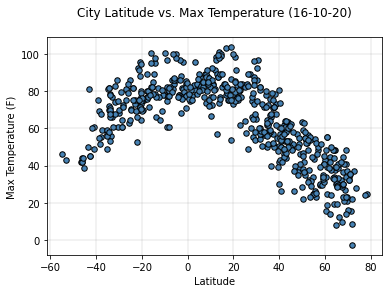

In [7]:
# Generating a scatter plot of Latitude vs. Temperature

y_lbl = "Max Temperature (F)"
title = "Max Temperature"
file_name = "Temp_vs_Lat.png"

# calling plot_vs_lat function
plot_vs_lat("Max Temp", y_lbl, title, file_name)


## Latitude vs. Humidity Plot

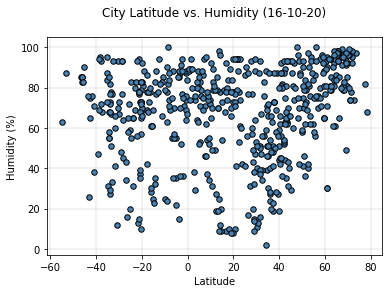

In [8]:
# Generating a scatter plot of Latitude vs. Humidity

y_lbl = "Humidity (%)"
title = "Humidity"
file_name = "Humidity_vs_Lat.png"

# calling plot_vs_lat function
plot_vs_lat("Humidity", y_lbl, title, file_name)


## Latitude vs. Cloudiness Plot

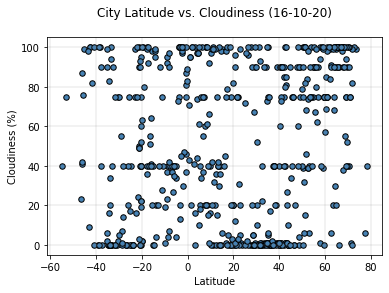

In [9]:
# Generating a scatter plot of Latitude vs. Cloudiness

y_lbl = "Cloudiness (%)"
title = "Cloudiness"
file_name = "Clouds_vs_Lat.png"

# calling plot_vs_lat function
plot_vs_lat("Cloudiness", y_lbl, title, file_name)


## Latitude vs. Wind Speed Plot

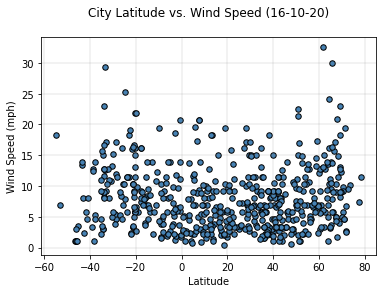

In [10]:
# Generating a scatter plot of Latitude vs. Wind Speed

y_lbl = "Wind Speed (mph)"
title = "Wind Speed"
file_name = "Wind_vs_Lat.png"

# calling plot_vs_lat function
plot_vs_lat("Wind Speed", y_lbl, title, file_name)


## Linear Regression

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

In [21]:
clean_city_data = clean_city_data.dropna(how='any')
north_city_data = clean_city_data[clean_city_data['Lat'] > 0]
south_city_data = clean_city_data[clean_city_data['Lat'] < 0]

In [22]:
# Setting Latitude and Max Temp of Northern Hemisphere into x and y value lists

def correlation_plot(x, y, anno_x, anno_y):
    
    x_values = x
    y_values = y

    # Calculating and Printing Pearson correlation coefficient 
    correlation = st.pearsonr(x_values, y_values)
    print(f"\nThe r-value is: {correlation[0]}")


    # Setting the figure size
    fig = plt.figure()

    # Creating subplot (1x1 grid, 1st subplot)
    ax = fig.add_subplot(1,1,1)


    # Finding slope and y intercept of line, r value, p value and standard error using scipy.stats.linregress function
    (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)

    # Print r square value
    print(f"r squared: {rvalue**2}")

    # Line equation y=mx+b
    regress_values = slope * x_values + intercept

    # Line equation string y=mx+b to diplay
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

    # Creating a scatter plot of Weight and Average Tumor volume
    plt.scatter(x_values, y_values, color='steelblue', s=30)

    # Creating a line plot (red solid)
    plt.plot(x_values, regress_values, "r-")

    # Adding line_eq string at specified position
    plt.annotate(line_eq,(anno_x, anno_y),fontsize=16,color="red")
    
    # Adding xlabel to the plot 
    plt.xlabel('Latitude')



The r-value is: -0.8688914943816822
r squared: 0.7549724290088329


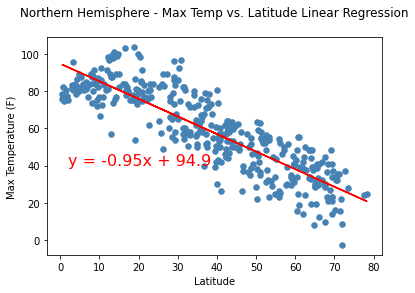

In [23]:
# Setting Latitude and Max Temp of Northern Hemisphere into x and y value lists

north_city_data = north_city_data.dropna(how='any')
# Calling correlation_plot function
correlation_plot(north_city_data['Lat'], north_city_data['Max Temp'], 2, 40)    

# Adding title and ylabel to the plot 
plt.title("Northern Hemisphere - Max Temp vs. Latitude Linear Regression\n")
plt.ylabel('Max Temperature (F)')

# Save figure as png file
plt.savefig("../Images/Temp_vs_Lat_North.png")

# Print our chart to the screen
plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression


The r-value is: 0.671423590136252
r squared: 0.4508096373914535


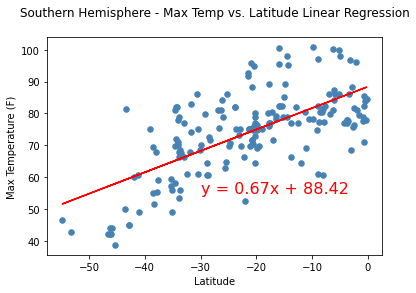

In [28]:
# Setting Latitude and Max Temp of Southern Hemisphere into x and y value lists

# Calling correlation_plot function
correlation_plot(south_city_data['Lat'], south_city_data['Max Temp'],-30,55)    

# Adding title and labels to the plot 
plt.title("Southern Hemisphere - Max Temp vs. Latitude Linear Regression\n")
plt.ylabel('Max Temperature (F)')

# Save figure as png file
plt.savefig("../Images/Temp_vs_Lat_South.png")

# Print our chart to the screen
plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression


The r-value is: 0.29862539296330975
r squared: 0.08917712532249117


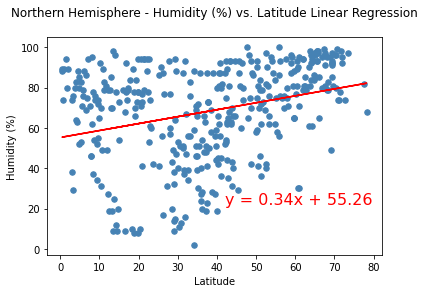

In [27]:
# Setting Latitude and Humidity of Northern Hemisphere into x and y value lists

# Calling correlation_plot function
correlation_plot(north_city_data['Lat'], north_city_data['Humidity'],42,22)

# Adding title and labels to the plot 
plt.title("Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression\n")
plt.ylabel('Humidity (%)')

# Save figure as png file
plt.savefig("../Images/Humidity_vs_Lat_North.png")

# Print our chart to the screen
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression


The r-value is: -0.017214821752235192
r squared: 0.00029635008796123017


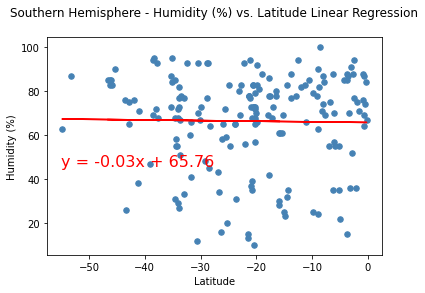

In [16]:
# Setting Latitude and Humidity of Southern Hemisphere into x and y value lists

# Calling correlation_plot function
correlation_plot(south_city_data['Lat'], south_city_data['Humidity'],-55,46)

# Adding title and labels to the plot 
plt.title("Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression\n")
plt.ylabel('Humidity (%)')

# Save figure as png file
plt.savefig("../Images/Humidity_vs_Lat_South.png")

# Print our chart to the screen
plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression


The r-value is: 0.26498347976887754
r squared: 0.07021624455042322


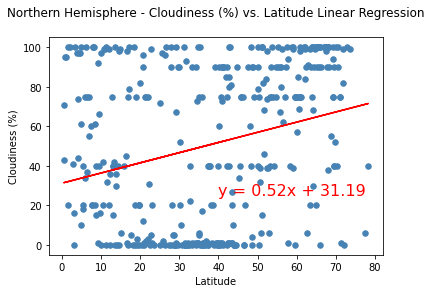

In [17]:
# Setting Latitude and Cloudiness of Northern Hemisphere into x and y value lists

# Calling correlation_plot function
correlation_plot(north_city_data['Lat'], north_city_data['Cloudiness'],40,25)

# Adding title and labels to the plot 
plt.title("Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression\n")
plt.ylabel('Cloudiness (%)')

# Save figure as png file
plt.savefig("../Images/Clouds_vs_Lat_North.png")

# Print our chart to the screen
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression


The r-value is: 0.15782356046901783
r squared: 0.02490827623911772


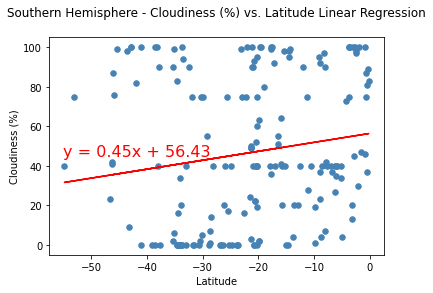

In [18]:
# Setting Latitude and Cloudiness of Southern Hemisphere into x and y value lists

# Calling correlation_plot function
correlation_plot(south_city_data['Lat'], south_city_data['Cloudiness'],-55,45)

# Adding title and labels to the plot 
plt.title("Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression\n")
plt.ylabel('Cloudiness (%)')

# Save figure as png file
plt.savefig("../Images/Clouds_vs_Lat_South.png")

# Print our chart to the screen
plt.show()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression


The r-value is: 0.19096191136465224
r squared: 0.03646645159204129


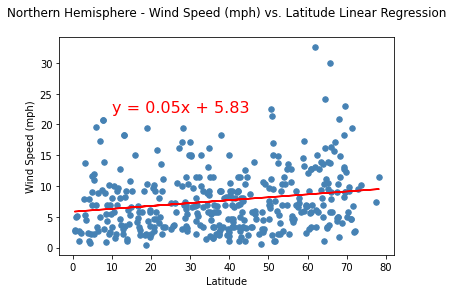

In [19]:
# Setting Latitude and Wind Speed of Northern Hemisphere into x and y value lists

# Calling correlation_plot function
correlation_plot(north_city_data['Lat'], north_city_data['Wind Speed'],10,22)

# Adding title and labels to the plot 
plt.title("Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression\n")
plt.ylabel('Wind Speed (mph)')

# Save figure as png file
plt.savefig("../Images/Wind_vs_Lat_North.png")

# Print our chart to the screen
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression


The r-value is: -0.09350974045042047
r squared: 0.008744071559105008


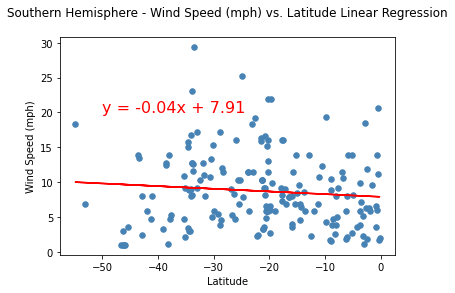

In [20]:
# Setting Latitude and Wind Speed of Southern Hemisphere into x and y value lists

# Calling correlation_plot function
correlation_plot(south_city_data['Lat'], south_city_data['Wind Speed'],-50,20)

# Adding title and labels to the plot 
plt.title("Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression\n")
plt.ylabel('Wind Speed (mph)')

# Save figure as png file
plt.savefig("../Images/Wind_vs_Lat_South.png")

# Print our chart to the screen
plt.show()